<a href="https://colab.research.google.com/github/YuxuanHuang455/PS-Microexpression/blob/main/Video-RL_GameDevelopment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Install the Packages and Set up the RL Env

To start, ensure all necessary libraries are installed. OpenAI Gym provides the RL environments, and W&B offers live monitoring.


In [ ]:
!pip install wandb scikit-learn optuna

import wandb
wandb.init(project="MicroExpression-Optimization", name="SVM-vs-LogReg")

wandb.login()

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from google.colab import files

# -------------------------------
# Step 1: Load micro-expression dataset
# -------------------------------
uploaded = files.upload()
data = pd.read_csv("micro_expression_causal_dataset.csv")


X = data[["imbalance"]]  # 这里用 imbalance 特征做示例
y = (data["macroF1"] > 0.55).astype(int)  # 把宏平均F1转为二分类标签（高/低表现）

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# Step 2: Optimization 1 (GridSearchCV for SVM)
# -------------------------------
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"]
}

svm = SVC()
grid = GridSearchCV(svm, param_grid, scoring="f1", cv=5, verbose=1)
grid.fit(X_train, y_train)

best_svm = grid.best_estimator_
y_pred_svm = best_svm.predict(X_test)

svm_acc = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)

wandb.log({"SVM accuracy": svm_acc, "SVM macro-F1": svm_f1})

# -------------------------------
# Step 3: Optimization 2 (Optuna for Logistic Regression)
# -------------------------------
def objective(trial):
    C = trial.suggest_float("C", 0.01, 10.0, log=True)
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    solver = "liblinear" if penalty=="l1" else "lbfgs"
    model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=1000)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return f1_score(y_test, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_params
logreg = LogisticRegression(**best_params, solver="liblinear", max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

lr_acc = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

wandb.log({"LogReg accuracy": lr_acc, "LogReg macro-F1": lr_f1})

print("SVM:", svm_acc, svm_f1)
print("Logistic Regression:", lr_acc, lr_f1)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Saving micro_expression_causal_dataset.csv to micro_expression_causal_dataset (1).csv
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[I 2025-09-27 03:39:49,512] A new study created in memory with name: no-name-7df94b60-d84e-4ac0-a79a-583931ac91ba
[I 2025-09-27 03:39:49,538] Trial 0 finished with value: 0.7189542483660131 and parameters: {'C': 9.058448124477339, 'penalty': 'l1'}. Best is trial 0 with value: 0.7189542483660131.
[I 2025-09-27 03:39:49,563] Trial 1 finished with value: 0.7172413793103448 and parameters: {'C': 1.6917105360987417, 'penalty': 'l2'}. Best is trial 0 with value: 0.7189542483660131.
[I 2025-09-27 03:39:49,579] Trial 2 finished with value: 0.7210884353741497 and parameters: {'C': 0.477335584290166, 'penalty': 'l1'}. Best is trial 2 with value: 0.7210884353741497.
[I 2025-09-27 03:39:49,594] Trial 3 finished with value: 0.0 and parameters: {'C': 0.03360965229991376, 'penalty': 'l2'}. Best is trial 2 with value: 0.7210884353741497.
[I 2025-09-27 03:39:49,609] Trial 4 finished with value: 0.6417910447761194 and parameters: {'C': 0.4966292644907382, 'penalty': 'l2'}. Best is trial 2 with value: 0.

SVM: 0.785 0.7295597484276729
Logistic Regression: 0.79 0.7123287671232876


Video saved: optimization_results.mp4


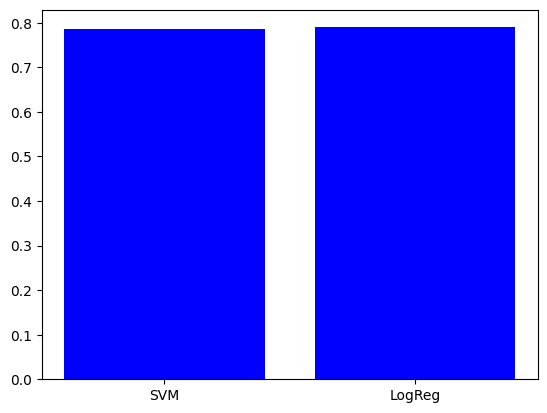

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Data for video (简单可视化: accuracy vs model)
models = ["SVM", "LogReg"]
accs = [svm_acc, lr_acc]
f1s = [svm_f1, lr_f1]

fig, ax = plt.subplots()
bars = ax.bar(models, accs, color="blue")

def animate(i):
    for bar, h in zip(bars, [svm_acc, lr_acc]):
        bar.set_height(h + 0.01*i*(lr_acc - svm_acc)/10)
    return bars

ani = animation.FuncAnimation(fig, animate, frames=10, blit=True)
ani.save("optimization_results.mp4", writer="ffmpeg")
print("Video saved: optimization_results.mp4")


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

models = ["SVM", "LogReg"]
baseline_acc = [0.5, 0.5]
baseline_f1 = [0.5, 0.5]

final_acc = [svm_acc, lr_acc]
final_f1 = [svm_f1, lr_f1]


fig, ax = plt.subplots(figsize=(6,5))
bars = ax.bar(models, baseline_acc, color=["blue","orange"])
ax.set_ylim(0,1)
ax.set_title("Accuracy Before vs After Training")

def animate_acc(frame):
    progress = frame / 20.0
    for bar, base, final in zip(bars, baseline_acc, final_acc):
        bar.set_height(base + (final-base)*progress)
    return bars

ani_acc = animation.FuncAnimation(fig, animate_acc, frames=21, blit=True, repeat=False)
ani_acc.save("Accuracy_Comparison.mp4", writer="ffmpeg", fps=5)
plt.close(fig)
print("file1: Accuracy_Comparison.mp4")


fig, ax = plt.subplots(figsize=(6,5))
bars = ax.bar(models, baseline_f1, color=["blue","orange"])
ax.set_ylim(0,1)
ax.set_title("Macro-F1 Before vs After Training")

def animate_f1(frame):
    progress = frame / 20.0
    for bar, base, final in zip(bars, baseline_f1, final_f1):
        bar.set_height(base + (final-base)*progress)
    return bars

ani_f1 = animation.FuncAnimation(fig, animate_f1, frames=21, blit=True, repeat=False)
ani_f1.save("MacroF1_Comparison.mp4", writer="ffmpeg", fps=5)
plt.close(fig)
print("file2: MacroF1_Comparison.mp4")


file1: Accuracy_Comparison.mp4


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow(

file2: MacroF1_Comparison.mp4
